In [23]:
import pandas as pd
import numpy as np
import xgboost
import catboost
from sklearn import metrics
from sklearn import tree
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from statsmodels.tsa.api import ExponentialSmoothing

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8')

# <center> Соревнование Моторика </center>
## Постановка задачи
Пилот - человек, с которого собираются данные. На руку пилота крепится манжета с датчиками, которые фиксируют движение мышц и связок руки пилота. В течение всей процедуры сбора данных зафиксированные датчиками данные записываются в файл. Пилоту поступают команды о выполнении жестов, пилот после получения команды с некоторой естественной задержкой выполняет жесты. Задача: обучить модель МО, которая сможет предсказывать какую команду жеста выполняет пилот по показаниям с датчиков, то есть решить задачу классификации.

## Данные

* Данные представляют из себя временные ряды, где в каждый момент времени фиксируются показания от датчиков.
* Целевая переменная представляет из себя закодированную команду поданную пользователю на выполнение жеста в каждый момент времени.

* X_train.npy и X_test.npy имеют следующие размерности (наблюдения, датчики, время);
* y_train.csv и y_test.csv имеют следующие размерности (наблюдения * время) - это обусловленно форматом ответов для Kaggle;
* y_train.csv содержит следующие классы:
    * 0 - команда "жест open";
    * 1 - команда "сгиб мизинца";
    * 2 - команда "сгиб безымянного пальца";
    * 3 - команда "сгиб среднего пальца";
    * 4 - команда "жест пистолет";
    * 5 - команда "сгиб указательного пальца";
    * 6 - команда "сгиб большога пальца";
    * 7 - команда "жест ОК";
    * 8 - команда "жест grab";


In [24]:
#Считываем данные
data_train = np.load('./data/X_train.npy')
data_test = np.load('./data/X_test.npy')

y_data_train = pd.read_csv('./data/y_train.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

print(data_train.shape, y_data_train.shape)
print(data_test.shape)

(323, 40, 100) (32300, 2)
(54, 40, 100)


In [25]:
y_data_train

,sample-timestep,class
0,0-0,0
1,0-1,0
2,0-2,0
3,0-3,0
4,0-4,0
...,...,...
32295,322-95,4
32296,322-96,4
32297,322-97,4
32298,322-98,4


Переведем y_train в нужный вид.

In [26]:
y_data_train[['sample_id', 'timestep']] = y_data_train['sample-timestep'].str.split('-', n=1, expand=True).astype(int)
y_data_train = y_data_train.pivot(index='sample_id', columns='timestep', values='class')
display(y_data_train)
y_train_index = y_data_train.index
y_data_train = y_data_train.sort_index() # на всякий случай
y_data_train = y_data_train.values

print(y_data_train.shape)
y_data_train

timestep,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
sample_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6
3,6,6,6,6,6,6,6,6,6,6,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,0,0,0,0,0,0,0,0,0,0,...,8,8,8,8,8,8,8,8,8,8
319,8,8,8,8,8,8,8,8,8,8,...,0,0,0,0,0,0,0,0,0,0
320,0,0,0,0,0,0,0,0,0,0,...,7,7,7,7,7,7,7,7,7,7


(323, 100)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 6, 6, 6],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]], dtype=int64)

## Анализ данных

Посмотрим на некоторые наблюдения, чтобы сделать какие-то выводы о наших данных и возможно их как-то "докрутить". Визуализируем показания с датчиков и то, какая команда жеста была передана.

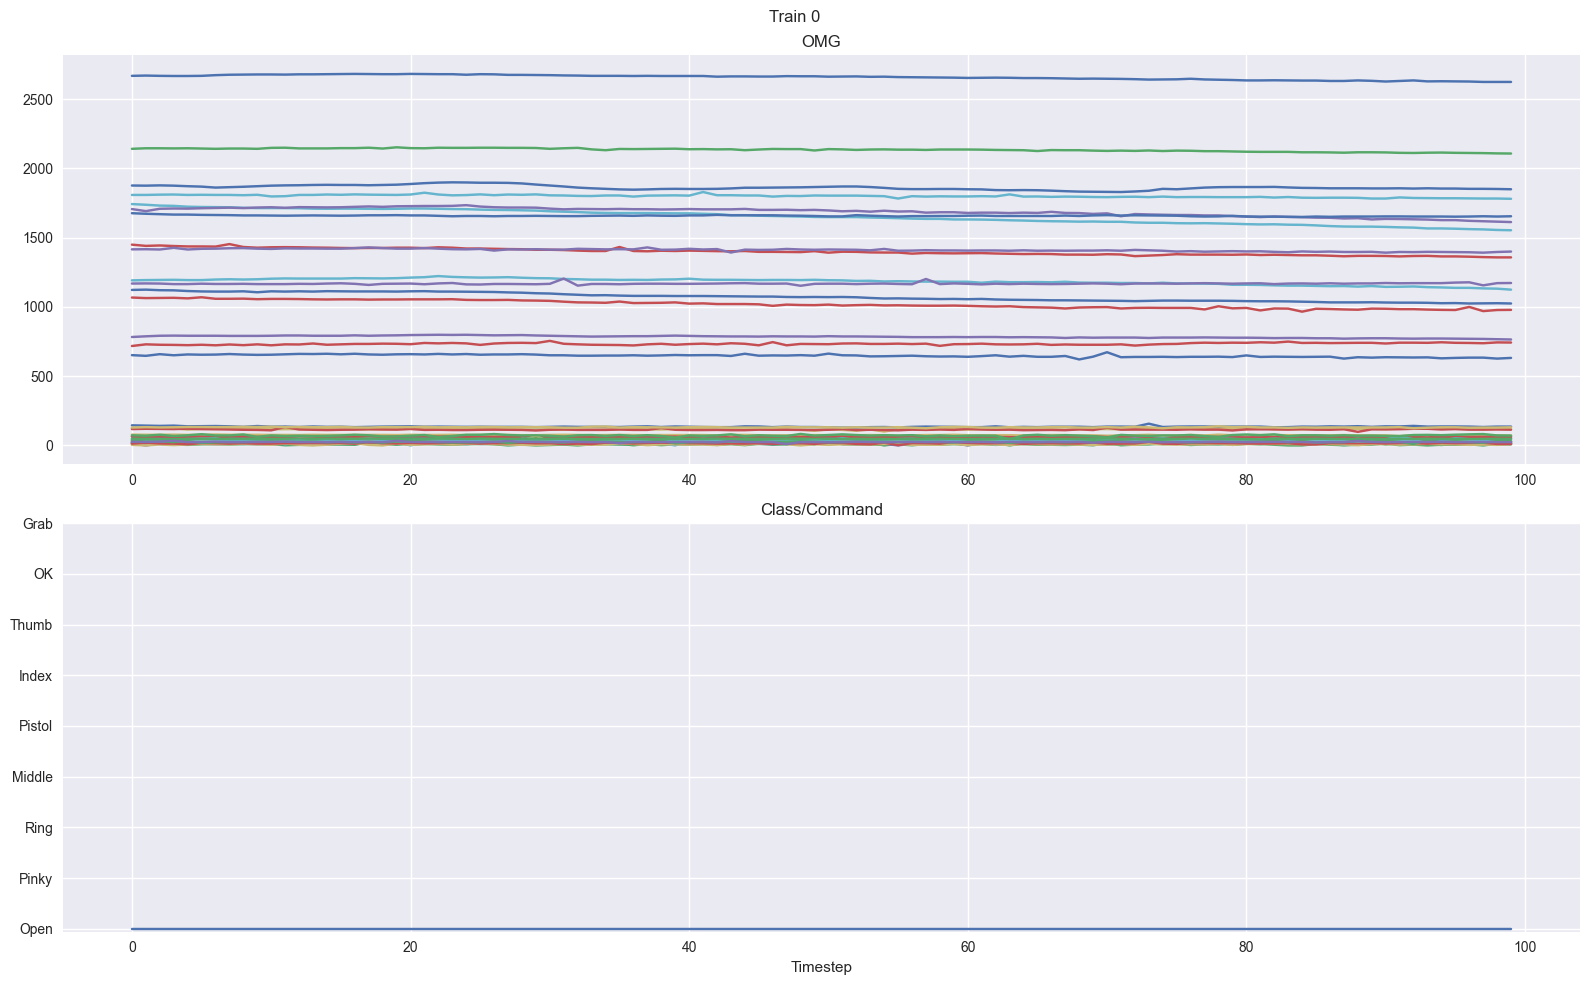

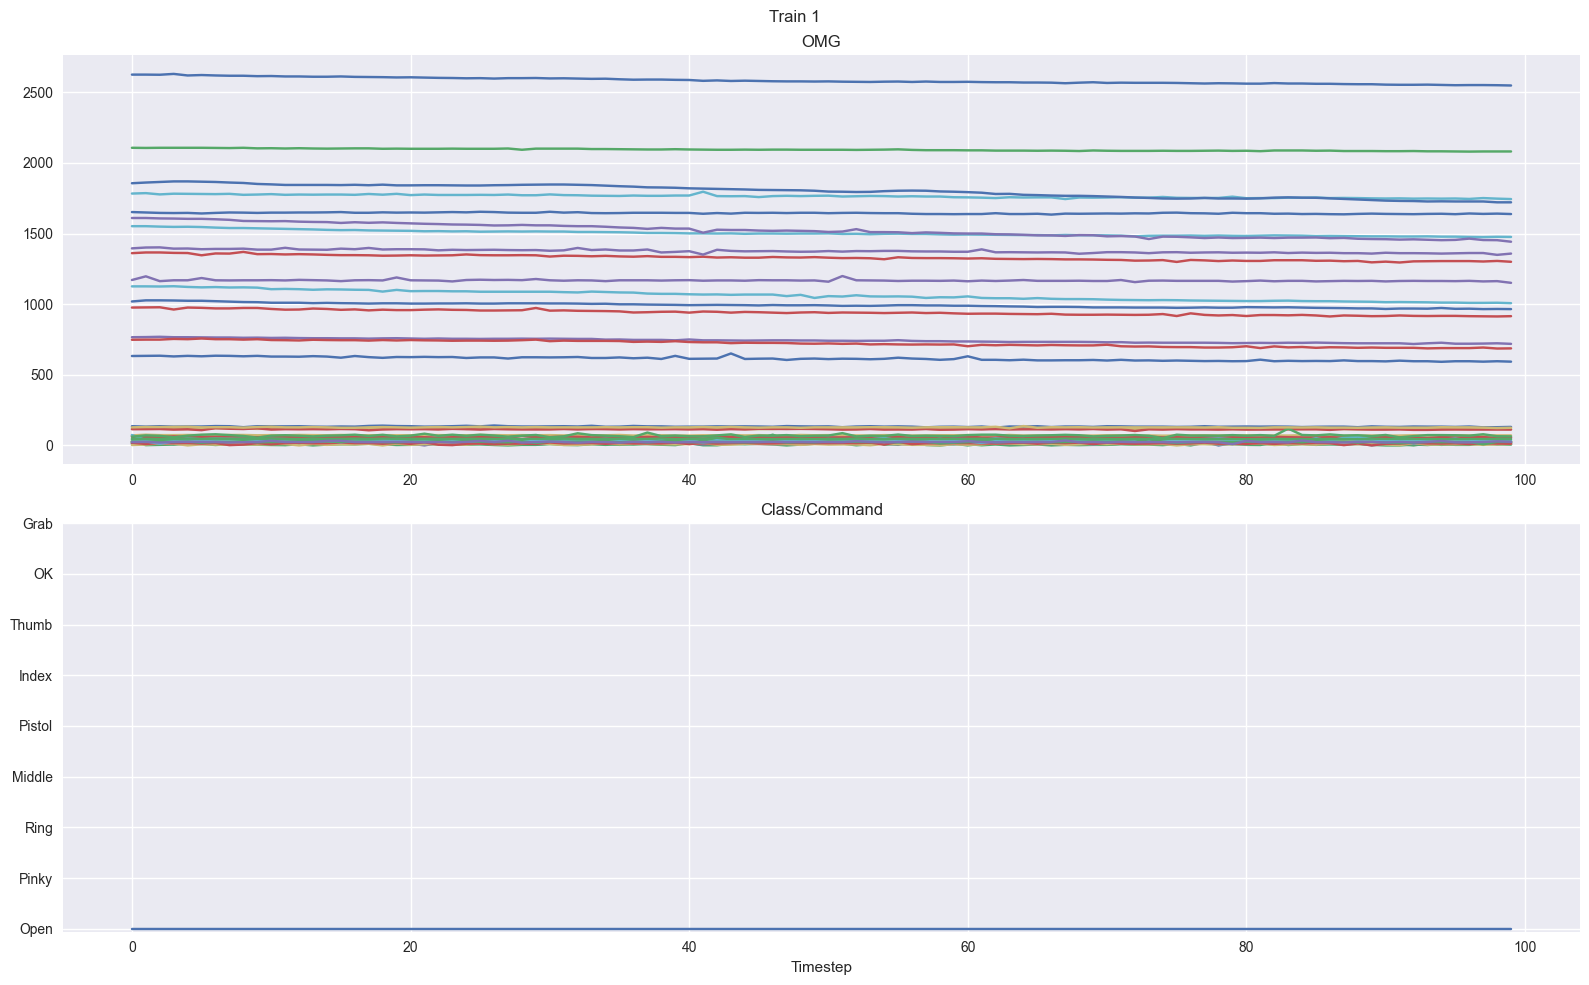

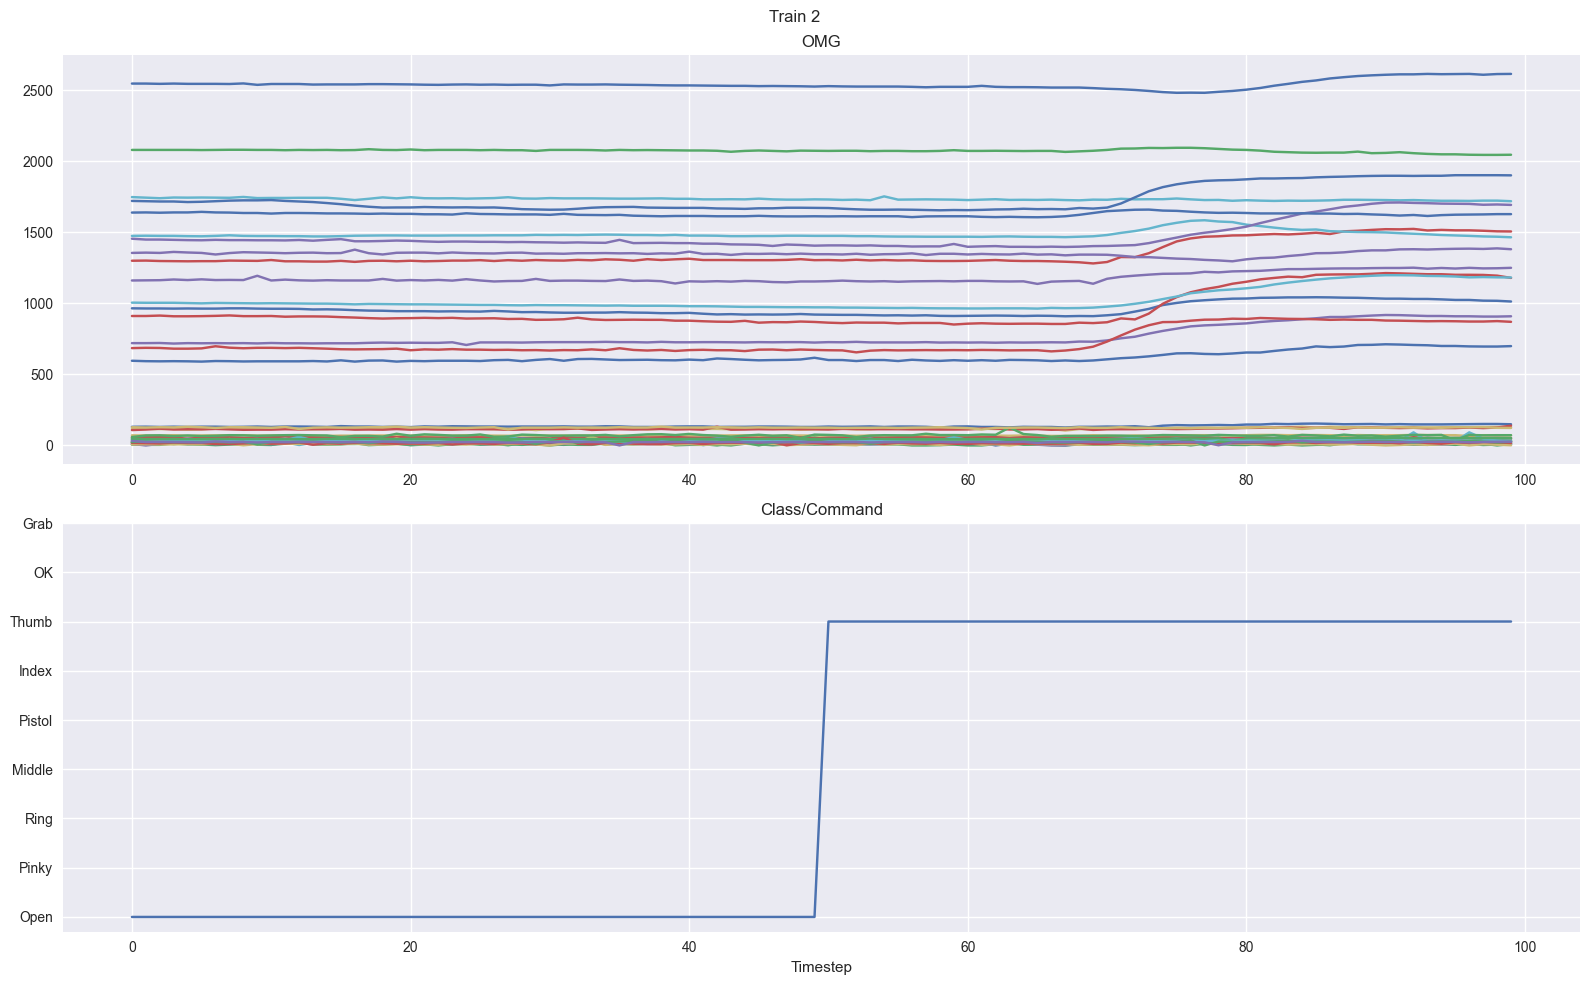

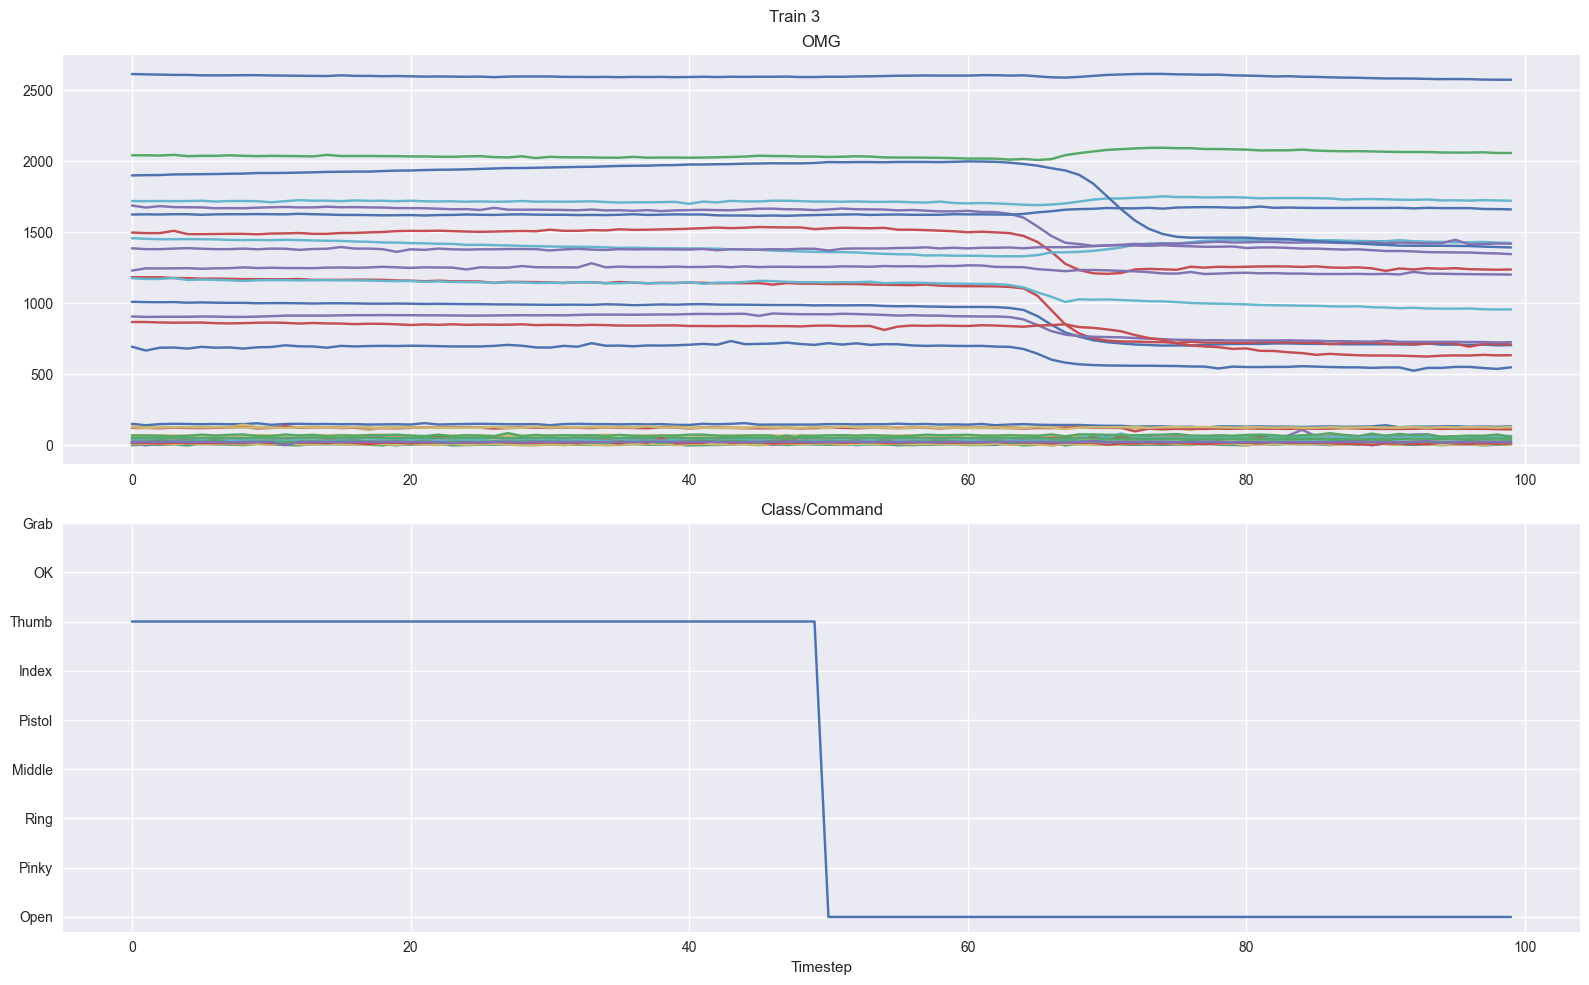

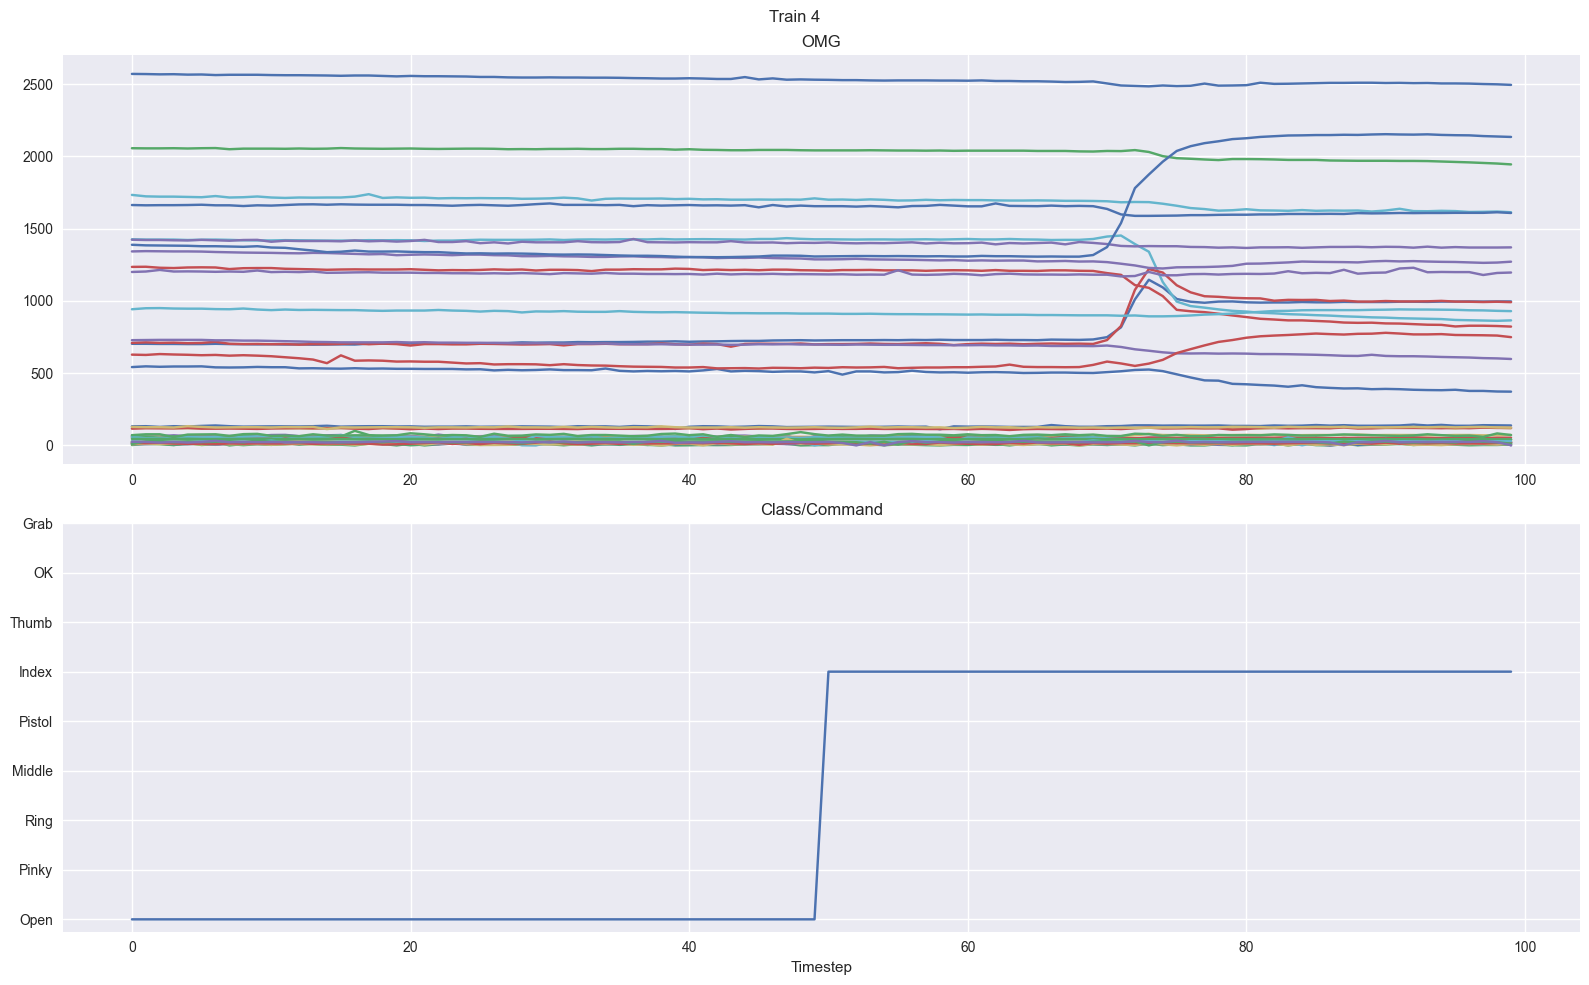

In [27]:
for i in range(5):
    fig, axx = plt.subplots(2, 1, figsize = (16, 10))
    
    axx[0].plot(data_train[i].T)
    axx[0].set_title('OMG')

    axx[1].plot(y_data_train[i])
    axx[1].set_title('Class/Command')
    axx[1].set_xlabel('Timestep')
    axx[1].set_yticks(
        np.arange(9),
        ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
    )

    plt.suptitle(f'Train {i}')

    plt.tight_layout()

Выводы:
Четка видна задержка между тем, как приходит команда на жест и тем, когда реагирует пилот. Для решения нашей задачи необходимо как-то избавиться от этой задержки.

Давайте преобразуем данные в нужный вид "соединив" наблюдения.

In [28]:
#Преобразуем data_train к нуждному виду
X_train = []
for sample in data_train:
    X_train += list(sample.T)
X_train = np.array(X_train)
print(f'X_train shape:{X_train.shape}')
#Преобразуем y_train к нужному виду
y_train = []
for sample in y_data_train:
    y_train += list(sample.T)
    
y_train = np.array(y_train)
print(f'y_train shape:{y_train.shape}')
#Преобразуем тестовые данные к нужному виду
X_test = []
for sample in data_test:
    X_test += list(sample.T)
    
X_test = np.array(X_test)
print(f'X_train shape:{X_test.shape}')

X_train shape:(32300, 40)
y_train shape:(32300,)
X_train shape:(5400, 40)


Создадим DataFrame из X_train

In [29]:
data_train = pd.DataFrame(X_train)
data_test = pd.DataFrame(X_test)

data_train.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,1123.0,10.0,1450.0,64.0,34.0,1743.0,145.0,12.0,1068.0,14.0,...,1877.0,73.0,13.0,1169.0,129.0,29.0,1677.0,36.0,718.0,26.0
1,1125.0,7.0,1441.0,66.0,33.0,1738.0,143.0,17.0,1064.0,0.0,...,1876.0,70.0,20.0,1170.0,132.0,28.0,1673.0,28.0,730.0,25.0
2,1121.0,17.0,1444.0,60.0,32.0,1732.0,141.0,10.0,1065.0,14.0,...,1878.0,77.0,14.0,1169.0,130.0,30.0,1670.0,29.0,727.0,27.0
3,1120.0,10.0,1440.0,59.0,32.0,1730.0,143.0,6.0,1066.0,13.0,...,1876.0,68.0,13.0,1165.0,131.0,29.0,1667.0,24.0,726.0,34.0
4,1115.0,16.0,1437.0,51.0,30.0,1724.0,138.0,4.0,1062.0,12.0,...,1872.0,73.0,9.0,1165.0,133.0,29.0,1667.0,32.0,724.0,24.0


Посмотрим корреляцию признаков.

Text(0.5, 1.0, 'Матрица корреляций')

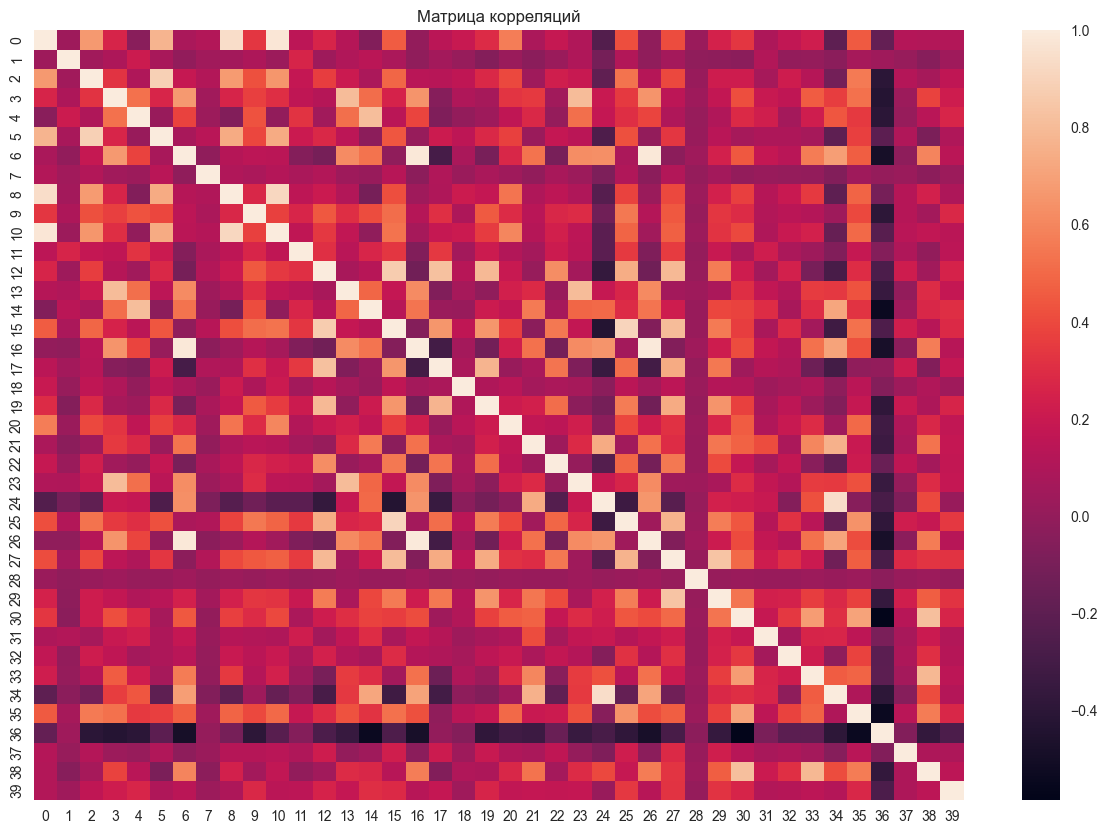

In [30]:
corr_matrix = data_train.corr()

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.heatmap(corr_matrix, ax=ax)
ax.set_title('Матрица корреляций')

Удалим признаки, которые вызывают мультиколлинеарность.

In [31]:
data_train = data_train.drop([8, 10, 16, 24, 25, 26], axis=1)
data_test = data_test.drop([8, 10, 16, 24, 25, 26], axis=1)

Добавим признак, который равен среднему по всем показателям с датчиков в единицу времени. 

In [32]:
data_train['mean_value'] = data_train.mean(axis=1)
data_test['mean_value'] = data_test.mean(axis=1)

Давайте добавим признаки скорости изменения показаний для каждого датчика, вычислять их будем по следующей форме:
$$v_i = x_{i} - x_{i-1}$$
, где $x_{i}$ - показания с датчика в i-ый момент времени, для первого и последнего показания пусть $v_i$ = 0.
Для реализации напишем функцию, так как нам придется проделывать этот же процесс и с тестовыми данными.

In [33]:
def get_rate_of_change(data):
    #Функция получает на вход данные, возвращает таблицу с добавленными признаками скорости изменениий показаний с датчиков.
    cols = data.columns
    for col in cols:
        data[f'speed_change_{col}'] = data[col].diff() #Считаем разницу соседних значений
        data[f'speed_change_{col}'] = data[f'speed_change_{col}'].fillna(data[f'speed_change_{col}'].mean()) #Пропуски заполняем средним значением
    return data

#Применяем полученную функцию к нашим данным
data_train = get_rate_of_change(data_train)
data_test = get_rate_of_change(data_test)

Теперь давайте попробуем избавиться от задержки. Первая идея, которая пришла мне в голову - это, используя визуализацию, оценить на глаз задержку и написать функцию шифтера, которая просто сдвинет все данные. Я воспользовался этим вариантом и он показал неплохие результаты, но я решил пойти дальше.

**Как убрать задержку:**
1. Находим абсолютное значение скорости изменения показаний в каждый момент времени для всех датчиков.
2. Считаем среднее скорости изменения показаний по всем датчикам в каждый момент времени
3. Из визуализации ранее можно сделать вывод, что если рассматривать по 100 единиц времени, то команда сообщается всегда в 50. Следовательно, пилот будет реагировать после этих 50, когда пилот реагирует, то датчики начинают изменять свои показания, следовательно, увеличивается и скорость изменения показаний. Таким образом, в момент реагирования пилота среднее скорости изменения показаний по всем датчикам будет достигать своего максимума на отрезке рассматриваемых 100 единиц времени.
4. Итак, нам нужно пройтись по всем нашим данным разделяя их по 100 наблюдений, в каждых 100 наблюдениях найти индекс наблюдения, у которого будет максимальное среднее скорости или другим языком среднее производной(причем в абсолютных значениях) и которое будет находиться между 50-ым и 100-ым наблюдениями этой сотни.
5. Удалить все наблюдения, которые находятся между 50-ыми и найдеными индексами в каждой сотне наблюдений.

In [34]:
def get_abs_rate_of_change(data):
    #Функция получает на вход данные, возвращает только признаки абсолютных скоростей изменений показаний с датчиков.
    data = data.copy()
    cols = data.columns
    for col in cols:
        data[f'speed_change_{col}'] = data[col].diff() #Считаем разницу соседних значений
        data[f'speed_change_{col}'] = data[f'speed_change_{col}'].fillna(data[f'speed_change_{col}'].mean()) #Пропуски заполняем средним значением
        data[f'abs_speed_change_{col}'] = data[f'speed_change_{col}'].apply(lambda x: abs(x)) #Получаем абсолютные значения
    return data.drop(cols, axis=1)

def avg_abs_rate_of_change(data):
    #Возвращает среднее абсолютных скоростей изменения по всем показаниям с датчиков
    speed_data = get_abs_rate_of_change(data)
    avg_abs_speed = speed_data.sum(axis=1) / speed_data.shape[1]
    return avg_abs_speed

def get_idx_of_max_speed(data):
    #Возвращает массив с индексами наблюдений, в которых значение среднего производных показаний с датчиков достигает максимума
    result = [] #Массив результатов
    avg_abs_speed = list(avg_abs_rate_of_change(data)) #Возвращаем все средние
    for i in range(1, 324): #Проходим по всем наблюдений разделяя их на сотни
        #Находим нужный индекс
        max_value = max(avg_abs_speed[100 * (i - 1):100 * i])
        idx = avg_abs_speed[100 * (i - 1):100 * i].index(max_value)
        result.append(idx)
    return result

def removing_the_delay(data_train, y_train):
    #Возвращает данные очищенные от задержки
    idx_list = get_idx_of_max_speed(data_train) #Получаем необходимые индексы
    y_train_list = list(y_train)
    mask_result = [] #Результат для матрицы наблюдений
    y_train_result = [] #Результат для вектора правильных ответов
    for i in range(1, 324): #Проходим по всем наблюдений разделяя их на сотни
        idx = idx_list[i-1] #Берем индекс
        y_train_temp = y_train_list[100 * (i - 1):100 * i] #Берем сто правильных ответов
        if idx < 50: #Если индекс меньше 50-ти
            #То оставляем все как есть
            mask_result = mask_result + [1] * 100
            y_train_result = y_train_result + y_train_temp
        else: #Иначе избавляемся от задержки
            mask_result = mask_result + [1] * 50 + [None] * (idx - 50) + [1] * (100 - idx)
            y_train_result = y_train_result + y_train_temp[:50] + y_train_temp[idx:]
    data_train['mask'] = mask_result
    data_train = data_train.dropna().drop('mask', axis=1)
    return data_train, y_train_result

#Избавляемся от задержки в данных
data_train, y_train = removing_the_delay(data_train, y_train)
print(len(y_train))
print(data_train.shape)

C:\Users\drfre\AppData\Local\Temp\ipykernel_19104\4036633640.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'abs_speed_change_{col}'] = data[f'speed_change_{col}'].apply(lambda x: abs(x)) #Получаем абсолютные значения
C:\Users\drfre\AppData\Local\Temp\ipykernel_19104\4036633640.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'speed_change_{col}'] = data[col].diff() #Считаем разницу соседних значений
C:\Users\drfre\AppData\Local\Temp\ipykernel_19104\4036633640.py:8: PerformanceWarning: DataFrame is highly fra

26471
(26471, 70)


## Обучение моделей

Формируем выборки наблюдений.

In [35]:
X_train = data_train.values
X_test = data_test.values

Обучим дерево моделей с подбором гиперпараметров с помощью GridSearchCV.

In [36]:
#Модель
dt_model = tree.DecisionTreeClassifier(random_state=42)
#Сетка параметров
param_grid = {
    'max_depth': np.arange(1, 100, 10),
    'min_samples_leaf': np.arange(1, 20, 4),
    'criterion': ['gini', 'entropy']
}
#Подбор гиперпараметров
grid_dt = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)
#Обучаем модель
grid_dt.fit(X_train, y_train)
print(f'best params: {grid_dt.best_params_}')
#Делаем предсказания на тренировочном наборе данных
y_train_predict = grid_dt.predict(X_train)
print(f'Metrics:  {metrics.f1_score(y_train, y_train_predict, average=None).mean()}')
#Делаем предсказания на тестовом наборе данных
y_test_predict = grid_dt.predict(X_test)
sample_submission['class'] = y_test_predict
sample_submission.to_csv('./submissions/solution_dt.csv', index=False)

best params: {'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 1}
0.9853718292346088


Обучим случайный лес моделей с подбором гиперпараметров с помощью GridSearchCV.

In [37]:
#Модель
rf_model = ensemble.RandomForestClassifier(max_depth=11, min_samples_leaf=1, criterion='gini', random_state=42)
#Сетка параметров
param_grid = {
    'n_estimators': np.arange(30, 300, 30)
}
#Подбор гиперпараметров
grid_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)
#Обучаем модель
grid_rf.fit(X_train, y_train)
print(f'best params: {grid_rf.best_params_}')
#Делаем предсказания на тренировочном наборе данных
y_train_predict = grid_rf.predict(X_train)
print(f'Metrics:  {metrics.f1_score(y_train, y_train_predict, average=None).mean()}')
#Делаем предсказания на тестовом наборе данных
y_test_predict = grid_rf.predict(X_test)
sample_submission['class'] = y_test_predict
sample_submission.to_csv('./submissions/solution_rf.csv', index=False)

best params: {'n_estimators': 30}
0.9947155847033502


Обучим xgb и catboost.

In [38]:
#Обучаем модель
gb_model = xgboost.XGBClassifier(random_state=42)
gb_model.fit(X_train, y_train)
#Делаем предсказания 
y_train_predict = gb_model.predict(X_train)
print(f'Metrics:  {metrics.f1_score(y_train, y_train_predict, average=None).mean()}')

y_test_predict = gb_model.predict(X_test)
sample_submission['class'] = y_test_predict
sample_submission.to_csv('./submissions/solution_xgb.csv', index=False)

1.0


In [39]:
#Обучаем модель
cat_model = catboost.CatBoostClassifier(random_state=42)
cat_model.fit(X_train, y_train)
#Делаем предсказания
y_train_predict = cat_model.predict(X_train)
print(f'Metrics:  {metrics.f1_score(y_train, y_train_predict, average=None).mean()}')

y_test_predict = cat_model.predict(X_test)
sample_submission['class'] = y_test_predict
sample_submission.to_csv('./submissions/solution_catb.csv', index=False)

Learning rate set to 0.093516
0:	learn: 1.6620657	total: 39.7ms	remaining: 39.7s
1:	learn: 1.4042905	total: 70.8ms	remaining: 35.3s
2:	learn: 1.2128596	total: 102ms	remaining: 33.8s
3:	learn: 1.0739024	total: 133ms	remaining: 33.1s
4:	learn: 0.9526797	total: 164ms	remaining: 32.7s
5:	learn: 0.8537734	total: 197ms	remaining: 32.7s
6:	learn: 0.7768994	total: 230ms	remaining: 32.7s
7:	learn: 0.7113875	total: 263ms	remaining: 32.6s
8:	learn: 0.6459400	total: 299ms	remaining: 32.9s
9:	learn: 0.5971484	total: 333ms	remaining: 33s
10:	learn: 0.5476564	total: 369ms	remaining: 33.1s
11:	learn: 0.5020153	total: 406ms	remaining: 33.4s
12:	learn: 0.4674042	total: 437ms	remaining: 33.2s
13:	learn: 0.4365730	total: 467ms	remaining: 32.9s
14:	learn: 0.4044085	total: 505ms	remaining: 33.1s
15:	learn: 0.3775503	total: 537ms	remaining: 33s
16:	learn: 0.3550560	total: 570ms	remaining: 32.9s
17:	learn: 0.3337218	total: 600ms	remaining: 32.7s
18:	learn: 0.3111261	total: 637ms	remaining: 32.9s
19:	learn: 0.

В итоге лучшую метрику на тестовом наборе данных в публичном leaderborde выдал catboost она равна 0.98301